In [1]:
#inspo
#https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6
#Load libaries
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [2]:
#Setting up reddit client
r = praw.Reddit(user_agent='MooseSubstantial7289',
                client_id='P2kPPjuj8KBFvXtTF0GzGg',
                client_secret='v38cMcD6YxH-BzeIAukSNK-lJDJoeA',
                check_for_async=False)

#Selecting subreddit
subreddit = r.subreddit('climbing')

In [3]:
climb = [*subreddit.top(limit=None)] # top posts all time

print(len(climb))
print(climb[0].title)


#data frame with titiles
title = [climb.title for climb in climb]
climb_df = pd.DataFrame({
    "title" : title,
})
climb_df.head()


996
Climbers for Net-neutrality: The net is an important, free and open resource for all climbers and mountaineers alike. Lets keep it that way!


,title
0,Climbers for Net-neutrality: The net is an imp...
1,I'm moving to Los Angeles in February and don'...
2,Got my 300 pound self up the wall
3,My sister's only exception in using a selfie s...
4,Got bored and photoshopped out climbers from b...


In [4]:
#Sentiment Analysis with VADER
sid = SentimentIntensityAnalyzer()
res = [*climb_df['title'].apply(sid.polarity_scores)] #applying pos/neg score to titles
sentiment_df = pd.DataFrame.from_records(res) #dictionary =>data frame
climb_df= pd.concat([climb_df,sentiment_df], axis=1, join='inner')

#threshold for positive negative
THRESHOLD = 0.2

conditions = [
    (climb_df['compound'] <= -THRESHOLD),
    (climb_df['compound'] > -THRESHOLD) & (climb_df['compound'] < THRESHOLD),
    (climb_df['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
climb_df['label'] = np.select(conditions, values)

climb_df.head()

,title,neg,neu,pos,compound,label
0,Climbers for Net-neutrality: The net is an imp...,0.000,0.796,0.204,0.6588,pos
1,I'm moving to Los Angeles in February and don'...,0.000,0.860,0.140,0.4767,pos
2,Got my 300 pound self up the wall,0.000,1.000,0.000,0.0000,neu
3,My sister's only exception in using a selfie s...,0.000,1.000,0.000,0.0000,neu
4,Got bored and photoshopped out climbers from b...,0.126,0.659,0.216,0.3612,pos


<Axes: xlabel='label', ylabel='Count'>

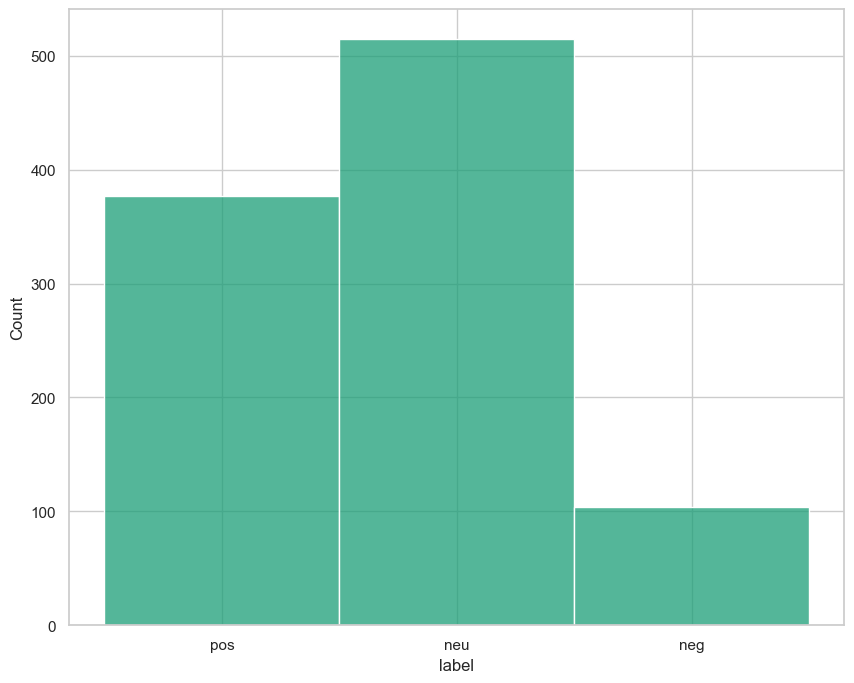

In [5]:
#counting up 
climb_df.label.value_counts()
sns.histplot(climb_df.label)

#Tokenisation

Can use some from NLTKs built in modules

word_tokenize — Splits string by punctuation other than periods

sent_tokenize — Splits a string into sentences

RegexpTokenize — Splits string based on a regular expression.

In [7]:
stop_words = stopwords.words('english')
#creating custom tokeniser
def custom_tokenize(text):
  # remove single quote and dashes and lowercase
  text = text.replace("'", "").replace("-", "").lower()

  # split on words only
  tk = nltk.tokenize.RegexpTokenizer(r'\w+')
  tokens = tk.tokenize(text)

  # remove stop words
  words = [w for w in tokens if not w in stop_words]
  return words

In [9]:
#Gives us a list of the key words in positive titles and words in negative titiles
def tokens_2_words(df, label):
  # subset titles based on label
  titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
  tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
  words = list(chain.from_iterable(tokens))
  return words

pos_words = tokens_2_words(climb_df, 'pos')
neg_words = tokens_2_words(climb_df, 'neg')

In [10]:
#Using NLTK built-in function to count words
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

[('climbing', 79),
 ('first', 37),
 ('friend', 28),
 ('made', 28),
 ('5', 28),
 ('climb', 27),
 ('wall', 25),
 ('new', 24),
 ('got', 24),
 ('one', 23),
 ('gym', 22),
 ('like', 21),
 ('top', 19),
 ('rock', 18),
 ('great', 17),
 ('super', 17),
 ('route', 16),
 ('last', 15),
 ('happy', 15),
 ('day', 15)]

#Word clouds

Word clouds can help visualise important words 


In [12]:
def plot_word_cloud(words, colormap, stopwords = [], max_words = 100):
  text = " ".join(word for word in words)
  # generate word cloud 
  wordcloud = WordCloud(width=1000, height = 600,
                        max_words = max_words,
                        colormap=colormap,
                        stopwords = stopwords,
                        background_color="black").generate(text)

  # Display the generated image:
  plt.figure( figsize=(20,10), facecolor='k' )
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off");

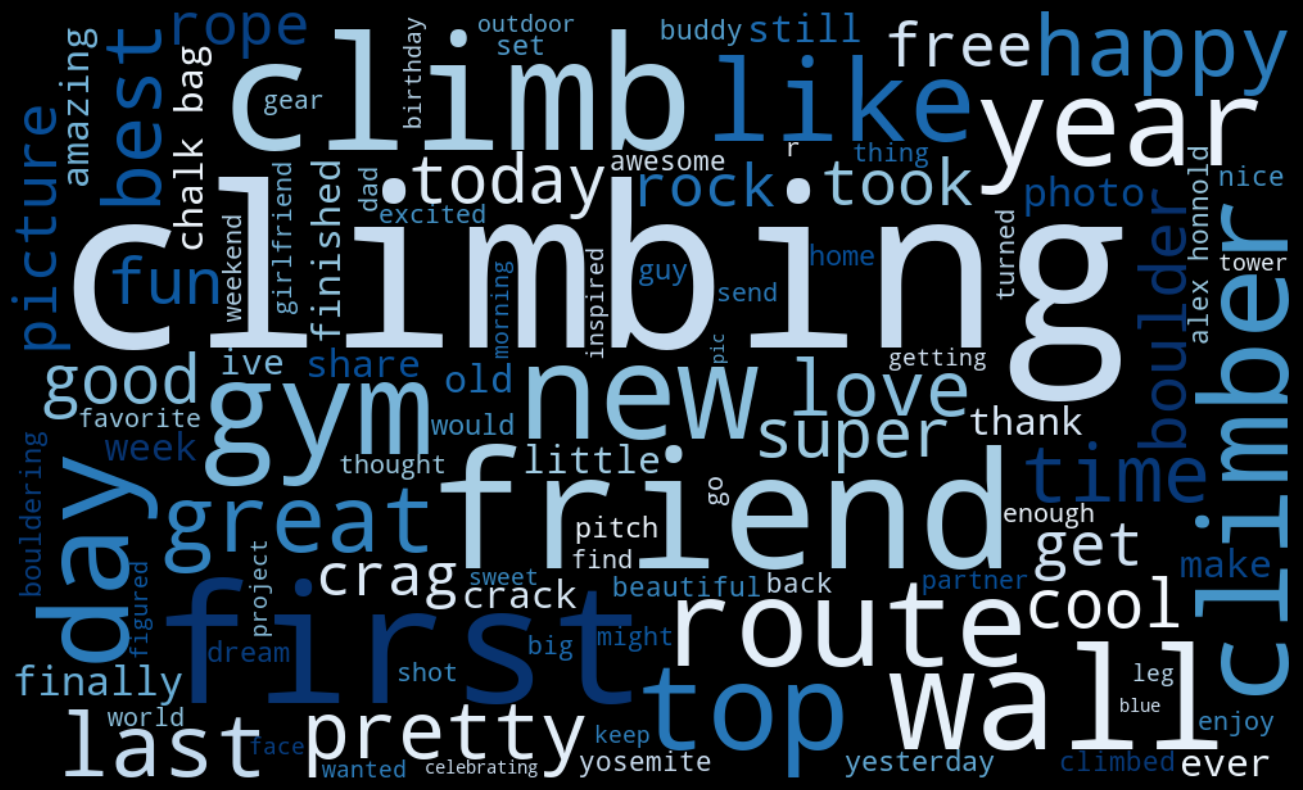

In [14]:
#picking custom stop words from the top 20 common
custom_stopwords = ["made", "one", "im", "got"]
plot_word_cloud(pos_words, "Blues", custom_stopwords)

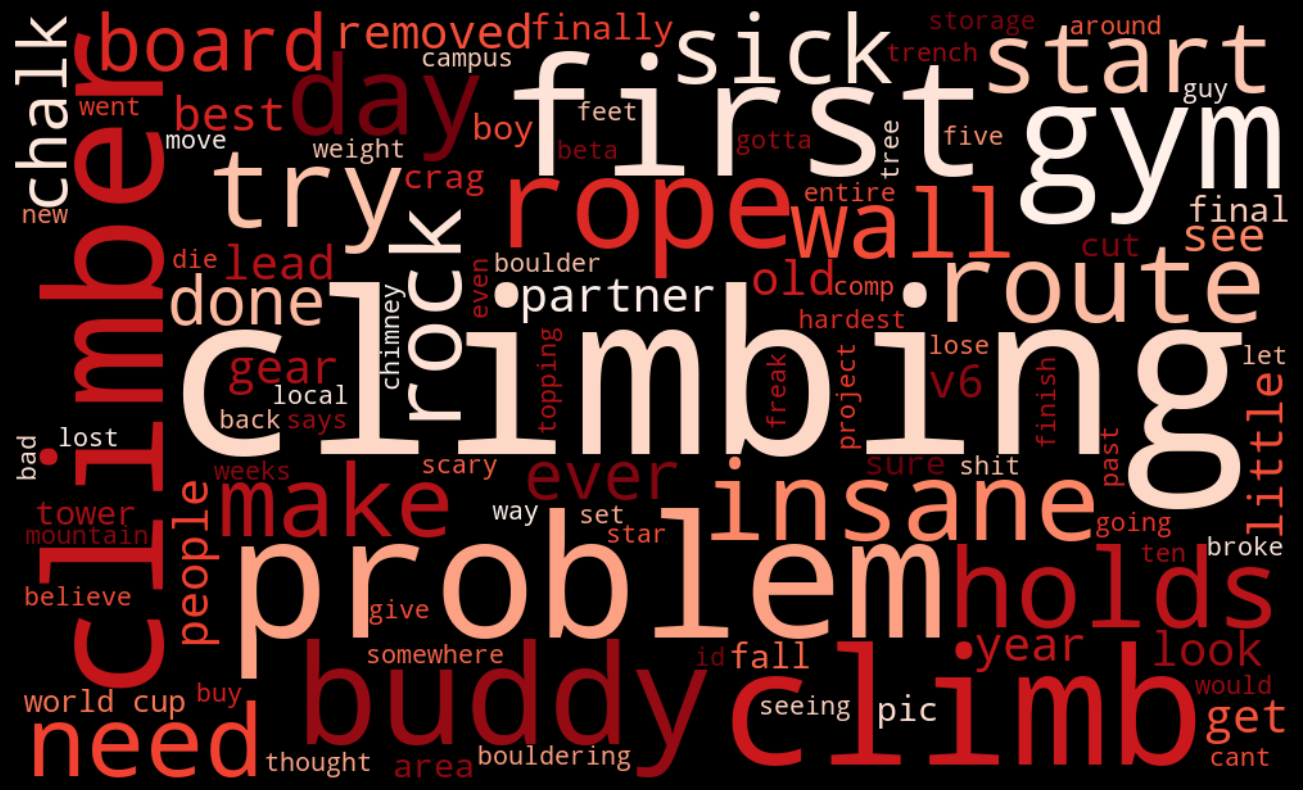

In [15]:
plot_word_cloud(neg_words, "Reds", custom_stopwords)

In [ ]:
#hello :)